In [1]:
#!pip install scikit-image
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import scipy.ndimage
import scipy.misc
from skimage.draw import polygon

### Building a Layered Velocity Model

In [ ]:
def add_layer(rows,start_value,end_value,cols=1200):
    # cols = width of layer (number of cells)
    # rows = depth of layer (number of cells)
    # start_value = starting Vp value
    # end_value = ending Vp value
    # Create the first layer with values increasing linearly
    linear_values = np.linspace(start_value, end_value, rows)
    layer = np.tile(linear_values.reshape(-1, 1), (1, cols))
    return layer[::-1]

# Create VP
lay1 = add_layer(50,3600,3600)
lay2 = add_layer(100,3800,3800)
lay3 = add_layer(250,4000,4000)
VP = np.vstack((lay3,lay2,lay1))

# Create VS
lay1 = add_layer(50,930,930)
lay2 = add_layer(100,930,930)
lay3 = add_layer(250,2600,2600)
RHO = np.vstack((lay3,lay2, lay1))

# Create RHO
lay1 = add_layer(50,1750,1750)
lay2 = add_layer(100,1900,1900)
lay3 = add_layer(250,2000,2000)
VS = np.vstack((lay3,lay2, lay1))


### Source and Receiver Geometry

In [ ]:
fdom = 100 # dominant source frequency [Hz]

SRCNAME='source'
NS = 1 #number of sources
ZS = 1. #depth of source
XSRC = np.arange(100,102,25)
YSRC = np.ones(len(XSRC))*int(ZS)
TD = np.zeros(len(XSRC)) #time-delay [s]
FC = np.ones(len(XSRC))*fdom #dom frequency [Hz]
AMP = np.ones(len(XSRC)) #signal amplitude
# Create an array with all the source parameters for write out to file
SRCMATRIX = np.vstack([XSRC,YSRC,TD,FC,AMP]) 

RECNAME='receiver'
#NR = 400 #number of receivers
ZR = 1 #depth of receiver
#startX = 0
#endX = 30000
#XREC = ( np.linspace(startX,endX,NR) ).astype(int)
XREC = np.arange(50,1150,1)
YREC = ( np.ones(len(XREC))*ZR ).astype(int) 
# Create an array with all the receiver parameters for write out to file
RECMATRIX = np.vstack([XREC,YREC])

### Plot Models with Acquisition Geometries
If everything plots as expected, then following cell can be executed to save experiment into folder structure needed for SOFI2D simulation

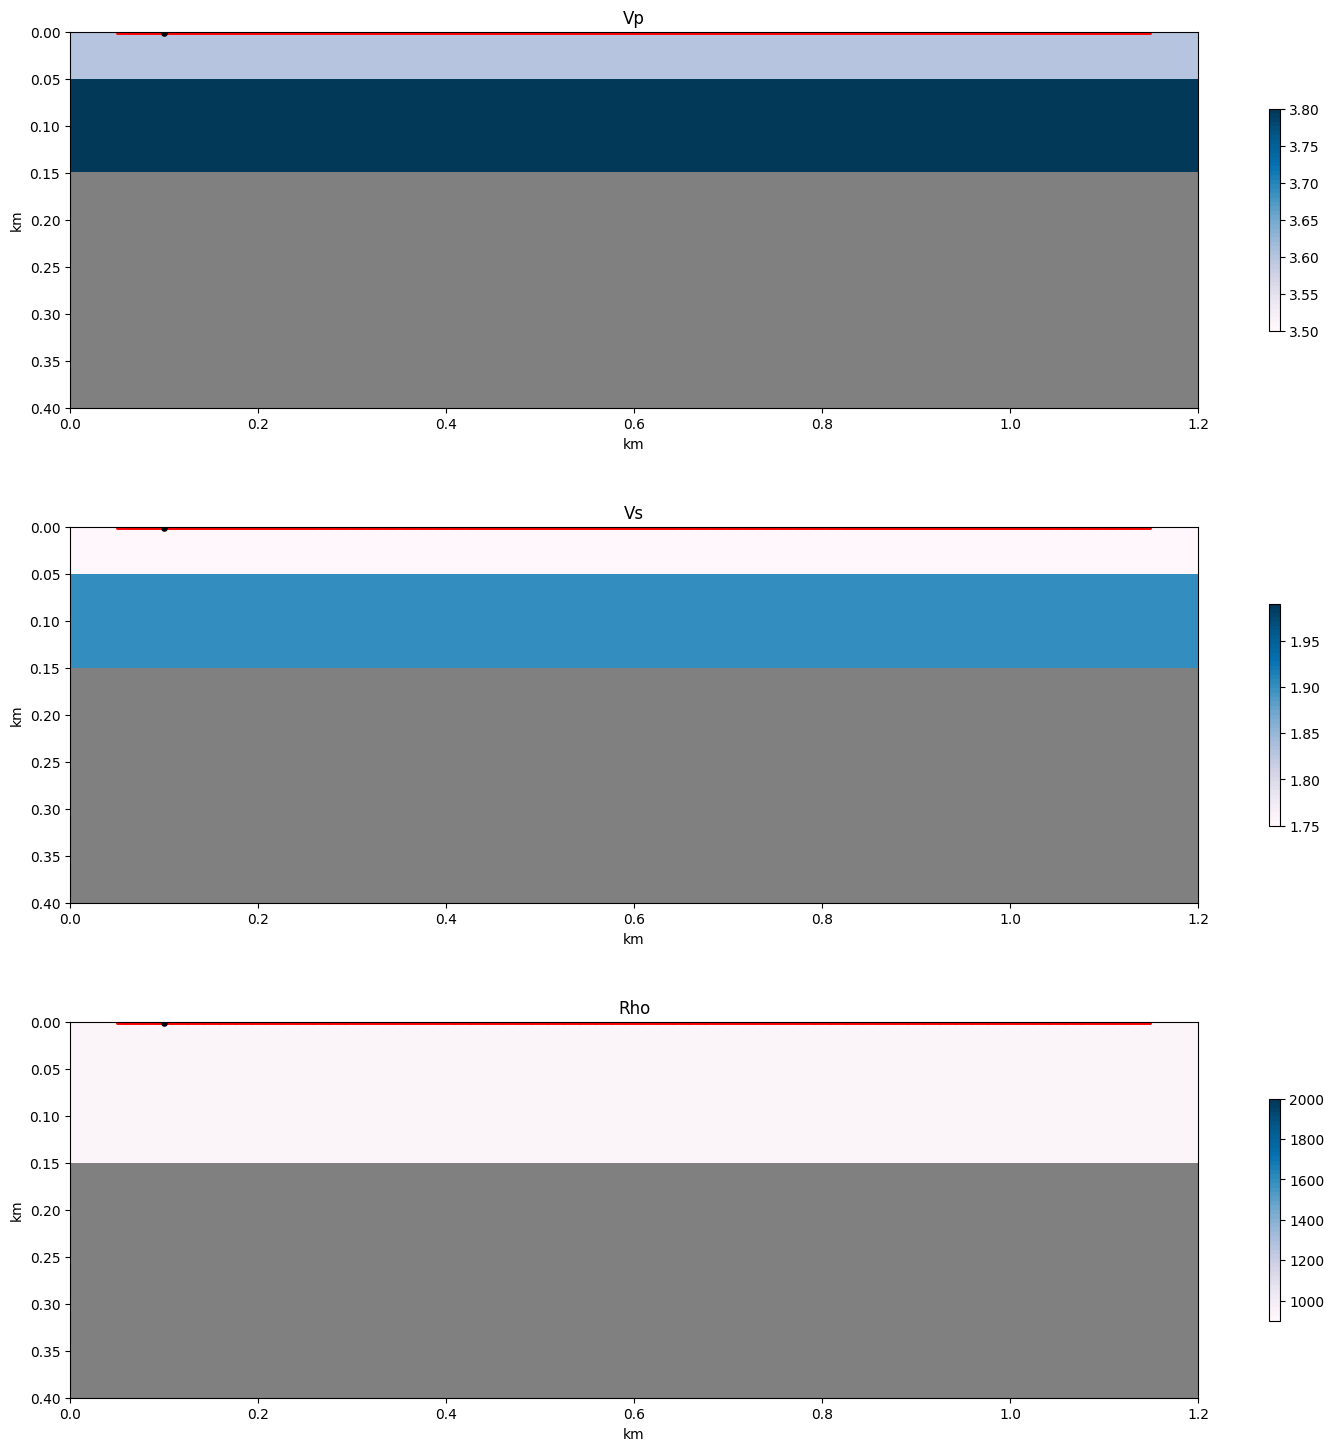

In [ ]:
# Name model and establish model dimensions for plotting
MDLNAME='2layer_toy'
dx=1 #m
dz=1 #m
lx = VP.shape[1]*dx #m
lz = VP.shape[0]*dz #m

cmap = plt.get_cmap('PuBu', 50)
cmap.set_under('yellow')
cmap.set_over('gray')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15))

# Plotting Vp, Vs, and Rho
for ax, data, title, vmin, vmax in zip([ax1, ax2, ax3], [VP/1000, VS/1000, RHO], ['Vp', 'Vs', 'Rho'], [3.5, 1.75, 900], [3.8, 1.99, 2000]):
    im = ax.imshow(np.fliplr(data), extent=[0, lx / 1000, 0, lz / 1000], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('km')
    ax.set_ylabel('km')
    plt.colorbar(im, ax=ax, shrink=0.5)

# Plotting receivers and sources
for ax in [ax1, ax2, ax3]:
    ax.scatter(XREC / 1000, YREC / 1000, 1, color='r')
    ax.scatter(XSRC / 1000, YSRC / 1000, 14, color='k')

plt.tight_layout()
plt.show()

### Export Source, Receiver, Model and other files for SOFI2D Execution

In [ ]:
# Save Source, Receiver and Model files
main_path='./ICE_toy/'
if not os.path.exists(main_path+'/sources'):
    os.makedirs(main_path+'/sources')
if not os.path.exists(main_path+'/receiver'):
    os.makedirs(main_path+'/receiver')
if not os.path.exists(main_path+'/model'):
    os.makedirs(main_path+'/model')
if not os.path.exists(main_path+'/in_and_out'):
    os.makedirs(main_path+'/in_and_out')
if not os.path.exists(main_path+'/log'):
    os.makedirs(main_path+'/log')
if not os.path.exists(main_path+'/snap'):
    os.makedirs(main_path+'/snap')
if not os.path.exists(main_path+'/su'):
    os.makedirs(main_path+'/su')

# #---save source---#
np.savetxt(main_path+'/sources/'+SRCNAME+'.dat', SRCMATRIX.T,fmt='%1.1f')

# # #---save receiver---#
np.savetxt(main_path+'/receiver/'+RECNAME+'.dat', RECMATRIX.T,fmt='%1.1f')

# #---save model---#
np.fliplr(VP.T).astype('float32').tofile(main_path+'/model/'+MDLNAME+'.vp')
np.fliplr(VS.T).astype('float32').tofile(main_path+'/model/'+MDLNAME+'.vs')
np.fliplr(RHO.T).astype('float32').tofile(main_path+'/model/'+MDLNAME+'.rho')

### Check Stability Conditions for FD Operators
Use this cell to guide you on whether the cell size (dx and dy) are suitable for the operator you want to use and the minimum velocity of your model and dominant frequency of your source. Additionally, this will guide you on the minimum timestep required for simulation.

<img src="image-20240723-132900.png" width="75%" align="" />

In [ ]:
vplim = {'vmax': VP.max()/1000, 'vmin': VP.min()/1000}
vslim = {'vmax': VS.max()/1000, 'vmin': VS.min()/1000}
rholim = {'vmax': RHO.max()/1000, 'vmin': RHO.min()/1000}
vlims = {'vp': vplim, 'vs': vslim, 'rho': rholim}

# FD Operators
Taylor  = { 'h':{ '2nd':1.0, '4th':7/6, '6th':149/120, '8th':2161/1680, '10th':53089/40320, '12th':1187803/887040 } , 'n':{ '2nd':12, '4th':8, '6th':6, '8th':5, '10th':5, '12th':4 } }
Holberg = { 'h':{ '2nd':1.0, '4th':1.184614, '6th':1.283482, '8th':1.345927, '10th':1.387660, '12th':1.417065 } , 'n':{ '2nd':12, '4th':8.32, '6th':4.77, '8th':3.69, '10th':3.19, '12th':2.91 } }

# Frequencies based on Source
fmax = 200 #Hz
fdom = 100  #Hz

# Velocities based on Model
cmax = vplim['vmax']*1000 #m/s
cmin = vslim['vmin']*1000 #m/s

if cmin < 1000:
    cmin = 1.0
    
print(f'Velocities range from {cmin:.0f} m/s to {cmax:.0f} m/s')

# Wavelengths Calculated
wlmin = cmin/fmax #m
wldom = cmin/fdom #m

print(f'Wavelength minimum:{wlmin:.0f}m\nWavelength dominant:{wldom:.0f}m')

# Furthest distance of wave propogation
distmax = max(lx,lz) #m
num_wldom_max = distmax/wldom
print(f'Approx number of wavelengths for traveling a max distance of {distmax:.0f} m is {num_wldom_max:.0f}')

# Grid spacing to be implemented (even in x and z)
order = '4th'
operator = Holberg

wl_sampling = operator['n'][order] #number of points per wavelength
dx_max = wlmin/wl_sampling #m
print(f'Grid spacing must be less than {dx_max:.3e}m to avoid numerical dispersion')

# Total number of grid points
lx_gridpts = lx/dx_max
lz_gridpts = lz/dx_max
tot_gridpts = lx_gridpts*lz_gridpts

# Time step 
CFL = 1/np.sqrt(2) #CFL criterion to be met (max physical velocity < grid velocity)
dt_max = ( CFL * dx_max ) / ( cmax * operator['h'][order] )
print(f'\nTo satisfy CFL of {CFL:.1f} with a grid spacing of {dx_max:.3e}m, time step needs to be less than {dt_max:.3e} seconds')

# Number of time steps
tmax = 8 #s desired recording time
nstep_max = tmax/dt_max
print(f'\nFor dt={dt_max:.3e}, run for {nstep_max:.3e} time steps for seismograms recorded over a total of {tmax} seconds')


#### ACTUAL SPACINGS AND GRID NUMBERS TO USE ####

# Actual grid spacing
dX = dx #m
dY = dz #m

# Actual number of grid points
X = int(lx/dX) #m grid points
Y = int(lz/dY) #m grid points

dT = ( CFL * dX ) / ( cmax * operator['h'][order] )
NSTEP = tmax/dT

print(f'\nActual grid spacing used in X and Y: {dX}m, {dY}m')
print(f'Actual number of grid points in X and Y: {X}, {Y}')
print(f'Actual max time step required: {dT:.3e} seconds')
print(f'Actual number of time steps required: {NSTEP:.1e}')

NameError: name 'VP' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7c29f6c-3012-4e48-acfa-06a0d6876a92' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>